In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from data_columns import *
import brate_trainer_rf_xgb
import importlib
brate_trainer_rf_xgb = importlib.reload(brate_trainer_rf_xgb)
from brate_trainer_rf_xgb import train_rf_xgb
from brate_trainer_rf_xgb import find_baseline

In [14]:
# To run RF and XGB over many parameter settings
# These are the deafult set
PARAMETERS = {
         'model_save_num': 270420220, 
         'output_file_name': 'redo_modFeat3_2_16_wind_size.csv',
         'aggr_wind_size':  '16', #['4', '8', '12', '16', '20', '24'], # '12',
         'horz_wind_size':  '2', #['2', '4', '6'], # '2',
         'pred_var': 'brate', # options ['brate', 'nseg']
         'model_type': ['rf', 'xgb'], # 'rf',
         'remove_ran_features': False,
         'remove_dash_features': False,
         'remove_prev_brate_val': False,
         #------------------
         'n_trees': 350,
         'tree_depth': 25,
         'min_samples_leaf': 2,
         'tree_depth_list': [25, 35, 50],
         'min_samples_leaf_list': [1, 5, 10],
          #----------------
         'train_size': 0,
         'test_size': 0,
         'runtime': 0,
         'accuracy': 0,
         'roc_auc': 0,
         'f1score': 0
        }
tune_hyperparam = False

START
2 16
acc, roc_auc, f1score:  0.9022471332339178 0.9922384881654983 0.8997849284440121
[[0.91809348 0.05830634 0.00694123 0.01619621 0.00046275 0.        ]
 [0.07597027 0.835673   0.0730801  0.01403799 0.00123865 0.        ]
 [0.0066568  0.06656805 0.83321006 0.0920858  0.00110947 0.00036982]
 [0.00057526 0.00191755 0.04065197 0.91447747 0.042186   0.00019175]
 [0.         0.         0.         0.05511655 0.93026472 0.01461873]
 [0.         0.         0.         0.         0.04036113 0.95963887]]


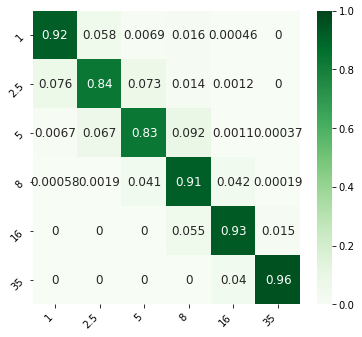

acc, roc_auc, f1score:  0.8702627654651103 0.9860519023546281 0.8640265427696275
[[0.85099491 0.07866728 0.02683943 0.02961592 0.00925497 0.00462749]
 [0.09454996 0.77952106 0.0912469  0.02477291 0.00536746 0.0045417 ]
 [0.02107988 0.07470414 0.79289941 0.10502959 0.00258876 0.00369822]
 [0.00575264 0.00517737 0.04717162 0.89146692 0.04928092 0.00115053]
 [0.00019755 0.00019755 0.00059265 0.06815488 0.90754642 0.02331094]
 [0.00053107 0.         0.         0.00212427 0.03611259 0.96123208]]


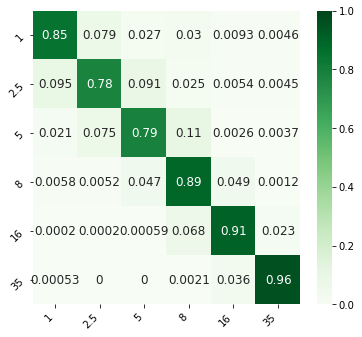

acc, roc_auc, f1score:  0.8828611096827275 0.988702880195344 0.8793441765028195
[[0.89865803 0.06385932 0.01758445 0.01665895 0.00323924 0.        ]
 [0.08009909 0.82989265 0.07349298 0.01238646 0.00330306 0.00082576]
 [0.0114645  0.08357988 0.79548817 0.10576923 0.00369822 0.        ]
 [0.00115053 0.00095877 0.04928092 0.89626079 0.05215724 0.00019175]
 [0.         0.         0.         0.05926511 0.91347294 0.02726195]
 [0.         0.         0.         0.         0.06107276 0.93892724]]


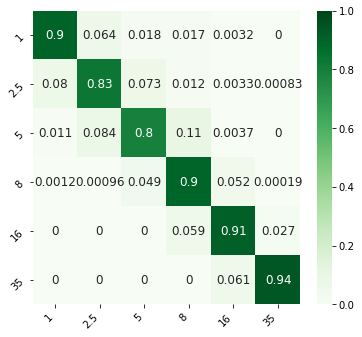

/home/akhila/opt/envs/dash_learning/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc, roc_auc, f1score:  0.906258034658302 0.9923533565787519 0.9020275991464198
[[0.91161499 0.06709857 0.01064322 0.00971772 0.0009255  0.        ]
 [0.07514451 0.83773741 0.07555739 0.01073493 0.00082576 0.        ]
 [0.00369822 0.07433432 0.83986686 0.08099112 0.00110947 0.        ]
 [0.00115053 0.00191755 0.03911793 0.91716203 0.04026846 0.00038351]
 [0.         0.00019755 0.00019755 0.04523904 0.93836428 0.01600158]
 [0.         0.00053107 0.         0.         0.03239511 0.96707382]]


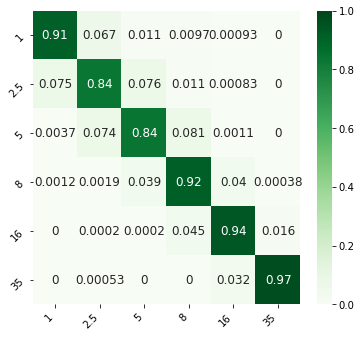

/home/akhila/opt/envs/dash_learning/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc, roc_auc, f1score:  0.866200442227593 0.9852590473950035 0.8589453825236547
[[0.83341046 0.092087   0.03331791 0.03192966 0.00555298 0.00370199]
 [0.09702725 0.78571429 0.08546656 0.02394715 0.00536746 0.00247729]
 [0.0214497  0.07840237 0.7862426  0.10650888 0.00369822 0.00369822]
 [0.00613615 0.00920422 0.04314477 0.88820709 0.05215724 0.00115053]
 [0.00098775 0.00138285 0.00098775 0.06519162 0.90675622 0.0246938 ]
 [0.00053107 0.0031864  0.00053107 0.00265534 0.04089219 0.95220393]]


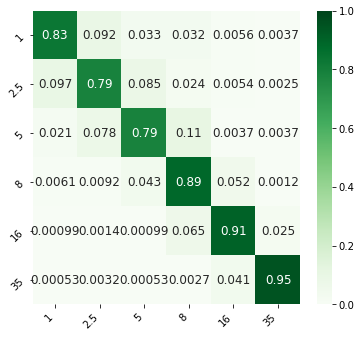

/home/akhila/opt/envs/dash_learning/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc, roc_auc, f1score:  0.888620352753638 0.9895136029123396 0.884808815474492
[[0.90374826 0.0731143  0.01295696 0.00879223 0.0009255  0.00046275]
 [0.08133774 0.81172585 0.09248555 0.01032205 0.00371594 0.00041288]
 [0.00776627 0.07877219 0.82618343 0.08542899 0.00147929 0.00036982]
 [0.00076702 0.00191755 0.04736337 0.8991371  0.0506232  0.00019175]
 [0.0003951  0.         0.0007902  0.05906756 0.92177005 0.01797708]
 [0.         0.         0.         0.         0.05841742 0.94158258]]


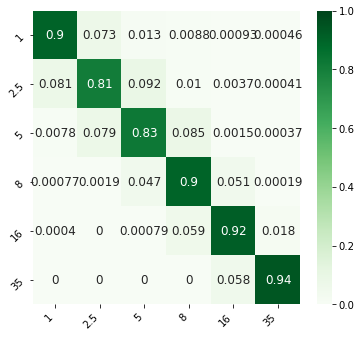

END


In [16]:
parameters = PARAMETERS.copy()
feature_comb = [[False, False, False],#, # all metrics
                [True, False, False], # remove RAN metrics
                [False, False, True]] # remove last segment history
                
model_types = ['rf', 'xgb']
aggr_wind_size = ['16']#['4','8','12','16','20','24']
horz_wind_size = ['2']#['2', '4', '6']
print('START')
for hw in horz_wind_size:
    for aw in aggr_wind_size:
        train_data_dir = '../data/data_train/dataset7-' \
                                    + hw + 'sWsize-' \
                                    + aw + 'aggsize/'
        print(hw, aw)
        for model_type in model_types:
            n = PARAMETERS['model_save_num']
            for feats in feature_comb:
                parameters['remove_ran_features'] = feats[0]
                parameters['remove_dash_features']= feats[1]
                parameters['remove_prev_brate_val']= feats[2]
                parameters['pred_var'] = 'brate'
                parameters['model_type'] = model_type
                parameters['model_save_num'] = n
                parameters['aggr_wind_size'] = aw
                parameters['horz_wind_size'] = hw
                model_save_path = '../models/'+ parameters['model_type']+'/model' + str(n) + '/'  
                n = n+1
                train_rf_xgb(parameters, train_data_dir, model_save_path, tune_hyperparam)  
print('END')

In [ ]:
# only last seg brate: 0.7111290601742342 0.8800698744549159 0.6838103076670311
#+1 0.6922633127560145 0.9066570564622012 0.6588707747271011
#+2 0.7283793919113829 0.9254896243457208 0.7000134200289029
#+3 0.7618415738764207 0.9450974820741336 0.737456466366819
#+4 0.8232273697571107 0.9622976496925079 0.7976109059411209
# from the dash+ran-last set 
#'mean-ThPutOverLastSeg_bps': 0.6153002942364276 0.861454818049792 0.5645359987425221
#2 0.6624935094905672 0.8957682826406911 0.6230655519536468
#3 0.6945133560260774 0.9190926009545007 0.6619332842225848
#4 0.8096117233023712 0.957278253635582 0.7835599718874547
#5 0.8288236312236774 0.962592455004251 0.803817207013997
#6 0.8315352218311891 0.966467258701123 0.8076255105582515

In [18]:
# find the baseline
parameters = PARAMETERS.copy()
train_data_dir = '../data/data_train/dataset7-' \
                                + '2' + 'sWsize-' \
                                + '16' + 'aggsize/'
find_baseline(PARAMETERS, train_data_dir)

Reading datset from:  ../data/data_train/dataset7-2sWsize-16aggsize/
Baseline
accuracy 0.6977425824034555 f1score 0.6814646708196128


## 

In [23]:
# Do this with raw data over all runs
import os
import load_data as ld
raw_data_path = "../data/raw_data/dataset7_35Mbps_max_brate_withCa/"
num_samples = 0
num_changes = 0
for r in os.listdir(raw_data_path):
    df_client_log = ld.load_dash_client_log(raw_data_path+r+"/dash_client_log.txt", 
                                        verbose=False)
    dash_client_node_ids = df_client_log['Node'].unique()
    for ue in dash_client_node_ids:
        df_client_log_per_node = df_client_log[df_client_log['Node'] == ue]
        num_samples = num_samples + len(df_client_log_per_node.index)
        df_client_log_changes = df_client_log_per_node[df_client_log_per_node['newBitRate_bps'] != df_client_log_per_node['oldBitRate_bps']]
        num_changes = num_changes + len(df_client_log_changes.index)
    
persistent_prediction_bitrate_acc = 1 - (num_changes/num_samples)
print("Persistent prediction accuracy values with raw samples")
print("Bitrate: " + str(persistent_prediction_bitrate_acc))

Persistent prediction accuracy values with raw samples
Bitrate: 0.6614886043669979
